# About this notebook

In this notebook the ordinary kriging algorithm is used to predict the amount of lead in the soil of the riverbank Meuse in the Netherlands. This is one of the textbook examples in Spatial statistics. The performance of making predictions with kriging is benchmarked with a simple nearest neighbours model. Finally a map is made by predicting a grid. The map is plot as a heatmap on top on an interactive map.

Modified from https://raw.githubusercontent.com/GeoStat-Framework/PyKrige/master/examples/kriging_meuse.ipynb

In [23]:
# This example requires some extra packages compared to the PyKrige package. 
# At the time of the creation, I used the conda package manager
# and installed the following (with the versions at the time):
# pandas 0.18.1, geopandas 0.2.1, seaborn 0.7.1, folium 0.2.1, shapely 1.5.16
# If you use pip, "pip install geopandas folium seaborn" should work to.
import os
import requests
import zipfile
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import folium
from folium import plugins
%matplotlib inline
from pykrige.ok import OrdinaryKriging
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pykrige.kriging_tools as kt
import seaborn as sb
from IPython.core.display import HTML
# HTML("<style>.container { width:70% !important; }</style>")

## Download and import the shapefile

- Download the zipfile from http://spatial-analyst.net/book/meusegrids
- Extract the zipfile
- Delete the zipfile

In [2]:
if(~os.path.isfile('./data/meuse.zip')):
    url = 'http://spatial-analyst.net/book/system/files/meuse.zip'
    results = requests.get(url)
    print('Status code download: {}'.format(results.status_code))
with open('./data/meuse.zip', 'wb') as f:
    f.write(results.content)
zip_ref = zipfile.ZipFile('./data/meuse.zip', 'r')
zip_ref.extractall('./data/meuse_example_data/')
zip_ref.close()
# os.remove('./data/meuse.zip')

Status code download: 200


In [3]:
meuse = gpd.read_file('data/meuse_example_data/meuse.shp')
meuse.crs = {'init':'epsg:28992'}
meuse['x'] = meuse['geometry'].apply(lambda x: x.x)
meuse['y'] = meuse['geometry'].apply(lambda x: x.y)
meuse.sample()

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,geometry,x,y
129,1.6,34.0,162.0,474.0,9.72,0.037337,7.5,2,1,0,W,170.0,POINT (180700.000 332882.000),180700.0,332882.0


## Spatial plot

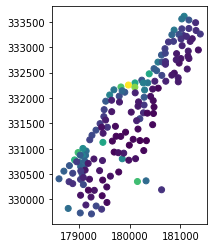

In [4]:
meuse.plot('lead')

In [24]:
feature_to_plot = 'lead'

meuse_lat_long = meuse.to_crs({'init': 'epsg:4326'})
meuse_lat_long['long'] = meuse_lat_long.geometry.apply(lambda x: x.x)
meuse_lat_long['lat'] = meuse_lat_long.geometry.apply(lambda x: x.y)
mean_long = np.mean(meuse_lat_long['long'])
mean_lat = np.mean(meuse_lat_long['lat'])
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
scale = folium.colormap.linear.YlOrRd.scale(vmin=0, vmax=meuse_lat_long[feature_to_plot].max())
for row in meuse_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=50, color=None, fill_opacity=1,
                    fill_color=scale(row[1][feature_to_plot])).add_to(m)
m.add_children(scale)

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Split the data into test and train

Control the random split with setting a seed so the results are reproducable.

In [6]:
np.random.seed(0)
test_indexes = np.random.choice(a=meuse.index, size=int(np.round(len(meuse.index.values)/4)))
train_indexes = [index for index in meuse.index if index not in test_indexes]
meuse_test = meuse.loc[test_indexes,:].copy()
meuse_train = meuse.loc[train_indexes,:].copy()
print('Number of observations in training: {}, in test: {}'.format(len(meuse_train), len(meuse_test)))

Number of observations in training: 122, in test: 39


# Neural Process

## Helpers

In [7]:
# From https://github.com/3springs/attentive-neural-processes
import torch
from torch import nn
import torch.nn.functional as F
import math
import numpy as np
# from .attention import Attention as PtAttention


class LSTMBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, dropout=0, batchnorm=False, bias=False, num_layers=1
    ):
        super().__init__()
        self._lstm = nn.LSTM(
                input_size=in_channels,
                hidden_size=out_channels,
                num_layers=num_layers,
                dropout=dropout,
                batch_first=True,
                bias=bias
        )

    def forward(self, x):
        return self._lstm(x)[0]


class NPBlockRelu2d(nn.Module):
    """Block for Neural Processes."""

    def __init__(
        self, in_channels, out_channels, dropout=0, batchnorm=False, bias=False
    ):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout)
        self.norm = nn.BatchNorm2d(out_channels) if batchnorm else False

    def forward(self, x):
        # x.shape is (Batch, Sequence, Channels)
        # We pass a linear over it which operates on the Channels
        x = self.act(self.linear(x))

        # Now we want to apply batchnorm and dropout to the channels. So we put it in shape
        # (Batch, Channels, Sequence, None) so we can use Dropout2d & BatchNorm2d
        x = x.permute(0, 2, 1)[:, :, :, None]

        if self.norm:
            x = self.norm(x)

        x = self.dropout(x)
        return x[:, :, :, 0].permute(0, 2, 1)


class BatchMLP(nn.Module):
    """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).

    Args:
        input: input tensor of shape [B,n,d_in].
        output_sizes: An iterable containing the output sizes of the MLP as defined 
            in `basic.Linear`.
    Returns:
        tensor of shape [B,n,d_out] where d_out=output_size
    """

    def __init__(
        self, input_size, output_size, num_layers=2, dropout=0, batchnorm=False
    ):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.initial = NPBlockRelu2d(
            input_size, output_size, dropout=dropout, batchnorm=batchnorm
        )
        self.encoder = nn.Sequential(
            *[
                NPBlockRelu2d(
                    output_size, output_size, dropout=dropout, batchnorm=batchnorm
                )
                for _ in range(num_layers - 2)
            ]
        )
        self.final = nn.Linear(output_size, output_size)

    def forward(self, x):
        x = self.initial(x)
        x = self.encoder(x)
        return self.final(x)


class AttnLinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=False)
        torch.nn.init.normal_(self.linear.weight, std=in_channels ** -0.5)

    def forward(self, x):
        x = self.linear(x)
        return x


class Attention(nn.Module):
    def __init__(
        self,
        hidden_dim,
        attention_type,
        attention_layers=2,
        n_heads=8,
        x_dim=1,
        rep="mlp",
        dropout=0,
        batchnorm=False,
    ):
        super().__init__()
        self._rep = rep

        if self._rep == "mlp":
            self.batch_mlp_k = BatchMLP(
                x_dim,
                hidden_dim,
                attention_layers,
                dropout=dropout,
                batchnorm=batchnorm,
            )
            self.batch_mlp_q = BatchMLP(
                x_dim,
                hidden_dim,
                attention_layers,
                dropout=dropout,
                batchnorm=batchnorm,
            )

        if attention_type == "uniform":
            self._attention_func = self._uniform_attention
        elif attention_type == "laplace":
            self._attention_func = self._laplace_attention
        elif attention_type == "dot":
            self._attention_func = self._dot_attention
        elif attention_type == "multihead":
            self._W_k = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)]
            )
            self._W_v = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)]
            )
            self._W_q = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)]
            )
            self._W = AttnLinear(n_heads * hidden_dim, hidden_dim)
            self._attention_func = self._multihead_attention
            self.n_heads = n_heads
        elif attention_type == "ptmultihead":
            self._W = torch.nn.MultiheadAttention(
                hidden_dim, n_heads, bias=False, dropout=dropout
            )
            self._attention_func = self._pytorch_multihead_attention
        else:
            raise NotImplementedError

    def forward(self, k, v, q):
        if self._rep == "mlp":
            k = self.batch_mlp_k(k)
            q = self.batch_mlp_q(q)
        rep = self._attention_func(k, v, q)
        return rep

    def _uniform_attention(self, k, v, q):
        total_points = q.shape[1]
        rep = torch.mean(v, dim=1, keepdim=True)
        rep = rep.repeat(1, total_points, 1)
        return rep

    def _laplace_attention(self, k, v, q, scale=0.5):
        k_ = k.unsqueeze(1)
        v_ = v.unsqueeze(2)
        unnorm_weights = torch.abs((k_ - v_) * scale)
        unnorm_weights = unnorm_weights.sum(dim=-1)
        weights = torch.softmax(unnorm_weights, dim=-1)
        rep = torch.einsum("bik,bkj->bij", weights, v)
        return rep

    def _dot_attention(self, k, v, q):
        scale = q.shape[-1] ** 0.5
        unnorm_weights = torch.einsum("bjk,bik->bij", k, q) / scale
        weights = torch.softmax(unnorm_weights, dim=-1)

        rep = torch.einsum("bik,bkj->bij", weights, v)
        return rep

    def _multihead_attention(self, k, v, q):
        outs = []
        for i in range(self.n_heads):
            k_ = self._W_k[i](k)
            v_ = self._W_v[i](v)
            q_ = self._W_q[i](q)
            out = self._dot_attention(k_, v_, q_)
            outs.append(out)
        outs = torch.stack(outs, dim=-1)
        outs = outs.view(outs.shape[0], outs.shape[1], -1)
        rep = self._W(outs)
        return rep

    def _pytorch_multihead_attention(self, k, v, q):
        # Pytorch multiheaded attention takes inputs if diff order and permutation
        q = q.permute(1, 0, 2)
        k = k.permute(1, 0, 2)
        v = v.permute(1, 0, 2)
        o = self._W(q, k, v)[0]
        return o.permute(1, 0, 2)


class LatentEncoder(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim=32,
        latent_dim=32,
        self_attention_type="dot",
        n_encoder_layers=3,
        min_std=0.01,
        batchnorm=False,
        dropout=0,
        attention_dropout=0,
        use_lvar=False,
        use_self_attn=False,
        attention_layers=2,
        use_lstm=False
    ):
        super().__init__()
        # self._input_layer = nn.Linear(input_dim, hidden_dim)
        if use_lstm:
            self._encoder = LSTMBlock(input_dim, hidden_dim, batchnorm=batchnorm, dropout=dropout, num_layers=n_encoder_layers)
        else:
            self._encoder = BatchMLP(input_dim, hidden_dim, batchnorm=batchnorm, dropout=dropout, num_layers=n_encoder_layers)
        if use_self_attn:
            self._self_attention = Attention(
                hidden_dim,
                self_attention_type,
                attention_layers,
                rep="identity",
                dropout=attention_dropout,
            )
        self._penultimate_layer = nn.Linear(hidden_dim, hidden_dim)
        self._mean = nn.Linear(hidden_dim, latent_dim)
        self._log_var = nn.Linear(hidden_dim, latent_dim)
        self._min_std = min_std
        self._use_lvar = use_lvar
        self._use_lstm = use_lstm
        self._use_self_attn = use_self_attn

    def forward(self, x, y):
        encoder_input = torch.cat([x, y], dim=-1)

        # Pass final axis through MLP
        encoded = self._encoder(encoder_input)

        # Aggregator: take the mean over all points
        if self._use_self_attn:
            attention_output = self._self_attention(encoded, encoded, encoded)
            mean_repr = attention_output.mean(dim=1)
        else:
            mean_repr = encoded.mean(dim=1)

        # Have further MLP layers that map to the parameters of the Gaussian latent
        mean_repr = torch.relu(self._penultimate_layer(mean_repr))

        # Then apply further linear layers to output latent mu and log sigma
        mean = self._mean(mean_repr)
        log_var = self._log_var(mean_repr)

        if self._use_lvar:
            # Clip it in the log domain, so it can only approach self.min_std, this helps avoid mode collapase
            # 2 ways, a better but untested way using the more stable log domain, and the way from the deepmind repo
            log_var = F.logsigmoid(log_var)
            log_var = torch.clamp(log_var, np.log(self._min_std), -np.log(self._min_std))
            sigma = torch.exp(0.5 * log_var)
        else:
            sigma = self._min_std + (1 - self._min_std) * torch.sigmoid(log_var * 0.5)
        dist = torch.distributions.Normal(mean, sigma)
        return dist, log_var


class DeterministicEncoder(nn.Module):
    def __init__(
        self,
        input_dim,
        x_dim,
        hidden_dim=32,
        n_d_encoder_layers=3,
        self_attention_type="dot",
        cross_attention_type="dot",
        use_self_attn=False,
        attention_layers=2,
        batchnorm=False,
        dropout=0,
        attention_dropout=0,
        use_lstm=False,
    ):
        super().__init__()
        self._use_self_attn = use_self_attn
        # self._input_layer = nn.Linear(input_dim, hidden_dim)
        if use_lstm:
            self._d_encoder = LSTMBlock(input_dim, hidden_dim, batchnorm=batchnorm, dropout=dropout, num_layers=n_d_encoder_layers)
        else:
            self._d_encoder = BatchMLP(input_dim, hidden_dim, batchnorm=batchnorm, dropout=dropout, num_layers=n_d_encoder_layers)
        if use_self_attn:
            self._self_attention = Attention(
                hidden_dim,
                self_attention_type,
                attention_layers,
                rep="identity",
                dropout=attention_dropout,
            )
        self._cross_attention = Attention(
            hidden_dim,
            cross_attention_type,
            x_dim=x_dim,
            attention_layers=attention_layers,
        )

    def forward(self, context_x, context_y, target_x):
        # Concatenate x and y along the filter axes
        d_encoder_input = torch.cat([context_x, context_y], dim=-1)

        # Pass final axis through MLP
        d_encoded = self._d_encoder(d_encoder_input)

        if self._use_self_attn:
            d_encoded = self._self_attention(d_encoded, d_encoded, d_encoded)

        # Apply attention as mean aggregation
        h = self._cross_attention(context_x, d_encoded, target_x)

        return h


class Decoder(nn.Module):
    def __init__(
        self,
        x_dim,
        y_dim,
        hidden_dim=32,
        latent_dim=32,
        n_decoder_layers=3,
        use_deterministic_path=True,
        min_std=0.01,
        use_lvar=False,
        batchnorm=False,
        dropout=0,
        use_lstm=False,
    ):
        super(Decoder, self).__init__()
        self._target_transform = nn.Linear(x_dim, hidden_dim)
        if use_deterministic_path:
            hidden_dim_2 = 2 * hidden_dim + latent_dim
        else:
            hidden_dim_2 = hidden_dim + latent_dim
            
        if use_lstm:
            self._decoder = LSTMBlock(hidden_dim_2, hidden_dim_2, batchnorm=batchnorm, dropout=dropout, num_layers=n_decoder_layers)
        else:
            self._decoder = BatchMLP(hidden_dim_2, hidden_dim_2, batchnorm=batchnorm, dropout=dropout, num_layers=n_decoder_layers)
        self._mean = nn.Linear(hidden_dim_2, y_dim)
        self._std = nn.Linear(hidden_dim_2, y_dim)
        self._use_deterministic_path = use_deterministic_path
        self._min_std = min_std
        self._use_lvar = use_lvar

    def forward(self, r, z, target_x):
        # concatenate target_x and representation
        x = self._target_transform(target_x)

        if self._use_deterministic_path:
            z = torch.cat([r, z], dim=-1)

        r = torch.cat([z, x], dim=-1)

        r = self._decoder(r)

        # Get the mean and the variance
        mean = self._mean(r)
        log_sigma = self._std(r)

        # Bound or clamp the variance
        if self._use_lvar:
            log_sigma = torch.clamp(log_sigma, math.log(self._min_std), -math.log(self._min_std))
            sigma = torch.exp(log_sigma)
        else:
            sigma = self._min_std + (1 - self._min_std) * F.softplus(log_sigma)

        dist = torch.distributions.Normal(mean, sigma)
        return dist, log_sigma


In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import math

# from src.models.modules import LatentEncoder, DeterministicEncoder, Decoder


def log_prob_sigma(value, loc, log_scale):
    """A slightly more stable (not confirmed yet) log prob taking in log_var instead of scale.
    modified from https://github.com/pytorch/pytorch/blob/2431eac7c011afe42d4c22b8b3f46dedae65e7c0/torch/distributions/normal.py#L65
    """
    var = torch.exp(log_scale * 2)
    return (
        -((value - loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))
    )


def kl_loss_var(prior_mu, log_var_prior, post_mu, log_var_post):
    """
    Analytical KLD for two gaussians, taking in log_variance instead of scale ( given variance=scale**2) for more stable gradients
    
    For version using scale see https://github.com/pytorch/pytorch/blob/master/torch/distributions/kl.py#L398
    """

    var_ratio_log = log_var_post - log_var_prior
    kl_div = (
        (var_ratio_log.exp() + (post_mu - prior_mu) ** 2) / log_var_prior.exp()
        - 1.0
        - var_ratio_log
    )
    kl_div = 0.5 * kl_div
    return kl_div

class LatentModel(nn.Module):
    def __init__(self,
                 x_dim, # features in input
                 y_dim, # number of features in output
                 hidden_dim=32, # size of hidden space
                 latent_dim=32, # size of latent space
                 latent_enc_self_attn_type="ptmultihead", # type of attention: "uniform", "dot", "multihead" "ptmultihead": see attentive neural processes paper
                 det_enc_self_attn_type="ptmultihead",
                 det_enc_cross_attn_type="ptmultihead",
                 n_latent_encoder_layers=2,
                 n_det_encoder_layers=2, # number of deterministic encoder layers
                 n_decoder_layers=2,
                 use_deterministic_path=False,
                 min_std=0.01, # To avoid collapse use a minimum standard deviation, should be much smaller than variation in labels
                 dropout=0,
                 use_self_attn=False,
                 attention_dropout=0,
                 batchnorm=False,
                 use_lvar=False, # Alternative loss calculation, may be more stable
                 attention_layers=2, 
                 use_rnn=True, # use RNN/LSTM?
                 use_lstm_le=False, # use another LSTM in latent encoder instead of MLP
                 use_lstm_de=False, # use another LSTM in determinstic encoder instead of MLP
                 use_lstm_d=False,  # use another lstm in decoder instead of MLP
                 context_in_target=True,
                 **kwargs,
                ):

        super(LatentModel, self).__init__()

        self._use_rnn = use_rnn

        if self._use_rnn:
            self._lstm = nn.LSTM(
                input_size=x_dim,
                hidden_size=hidden_dim,
                num_layers=attention_layers,
                dropout=dropout,
                batch_first=True
            )
            x_dim = hidden_dim

        self._latent_encoder = LatentEncoder(
            x_dim + y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            self_attention_type=latent_enc_self_attn_type,
            n_encoder_layers=n_latent_encoder_layers,
            attention_layers=attention_layers,
            dropout=dropout,
            use_self_attn=use_self_attn,
            attention_dropout=attention_dropout,
            batchnorm=batchnorm,
            min_std=min_std,
            use_lvar=use_lvar,
            use_lstm=use_lstm_le,
        )

        self._deterministic_encoder = DeterministicEncoder(
            input_dim=x_dim + y_dim,
            x_dim=x_dim,
            hidden_dim=hidden_dim,
            self_attention_type=det_enc_self_attn_type,
            cross_attention_type=det_enc_cross_attn_type,
            n_d_encoder_layers=n_det_encoder_layers,
            attention_layers=attention_layers,
            use_self_attn=use_self_attn,
            dropout=dropout,
            batchnorm=batchnorm,
            attention_dropout=attention_dropout,
            use_lstm=use_lstm_de,
        )

        self._decoder = Decoder(
            x_dim,
            y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            dropout=dropout,
            batchnorm=batchnorm,
            min_std=min_std,
            use_lvar=use_lvar,
            n_decoder_layers=n_decoder_layers,
            use_deterministic_path=use_deterministic_path,
            use_lstm=use_lstm_d,
            
        )
        self._use_deterministic_path = use_deterministic_path
        self._use_lvar = use_lvar
        self.context_in_target = context_in_target

    def forward(self, context_x, context_y, target_x, target_y=None):

        if self._use_rnn:
            # see https://arxiv.org/abs/1910.09323 where x is substituted with h = RNN(x)
            # x need to be provided as [B, T, H]
            target_x, _ = self._lstm(target_x)
            context_x, _ = self._lstm(context_x)

        dist_prior, log_var_prior = self._latent_encoder(context_x, context_y)

        if target_y is not None:
            dist_post, log_var_post = self._latent_encoder(target_x, target_y)
            z = dist_post.loc
        else:
            z = dist_prior.loc

        num_targets = target_x.size(1)
        z = z.unsqueeze(1).repeat(1, num_targets, 1)  # [B, T_target, H]

        if self._use_deterministic_path:
            r = self._deterministic_encoder(context_x, context_y,
                                            target_x)  # [B, T_target, H]  
        else:
            r = None

        dist, log_sigma = self._decoder(r, z, target_x)
        if target_y is not None:

            if self._use_lvar:
                log_p = log_prob_sigma(target_y, dist.loc, log_sigma).mean(-1)  # [B, T_target, Y].mean(-1)
                if self.context_in_target:
                    log_p[:, :context_x.size(1)] /= 100
                kl_loss = kl_loss_var(dist_prior.loc, log_var_prior,
                                      dist_post.loc, log_var_post).mean(-1)  # [B, R].mean(-1)
            else:
                log_p = dist.log_prob(target_y).mean(-1)
                if self.context_in_target:
                    log_p[:, :context_x.size(1)] /= 100 # There's the temptation for it to fit only on context, where it knows the answer, and learn very low uncertainty. 
                kl_loss = torch.distributions.kl_divergence(
                    dist_post, dist_prior).mean(-1)  # [B, R].mean(-1)
            kl_loss = kl_loss[:, None].expand(log_p.shape)
            mse_loss = F.mse_loss(dist.loc, target_y, reduction='none')[:, :context_x.size(1)].mean()
            loss = (kl_loss - log_p).mean()

        else:
            log_p = None
            mse_loss = None
            kl_loss = None
            loss = None

        y_pred = dist.rsample() if self.training else dist.loc
        return y_pred, dict(loss=loss, loss_p=-log_p.mean(), loss_kl=kl_loss, loss_mse=mse_loss.mean()), dict(log_sigma=log_sigma, dist=dist)


In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch

def npsample_batch(x, y, size=None, sort=False):
    """Sample from numpy arrays along 2nd dim."""
    inds = np.random.choice(range(x.shape[1]), size=size, replace=False)
    return x[:, inds], y[:, inds]

def collate_fns(max_num_context, max_num_extra_target, sample, sort=True, context_in_target=True):
    def collate_fn(batch, sample=sample):
        # Collate
        x = np.stack([x for x, y in batch], 0)
        y = np.stack([y for x, y in batch], 0)

        # Sample a subset of random size
        num_context = np.random.randint(4, max_num_context)
        num_extra_target = np.random.randint(4, max_num_extra_target)

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        
        x_context = x[:, :max_num_context]
        y_context = y[:, :max_num_context]
    
        x_target_extra = x[:, max_num_context:]
        y_target_extra = y[:, max_num_context:]
        
        if sample:

            x_context, y_context = npsample_batch(
                x_context, y_context, size=num_context
            )

            x_target_extra, y_target_extra = npsample_batch(
                x_target_extra, y_target_extra, size=num_extra_target, sort=sort
            )

        # do we want to compute loss over context+target_extra, or focus in on only target_extra?
        if context_in_target:
            x_target = torch.cat([x_context, x_target_extra], 1)
            y_target = torch.cat([y_context, y_target_extra], 1)
        else:
            x_target = x_target_extra
            y_target = y_target_extra

        
        return x_context, y_context, x_target, y_target

    return collate_fn


class DataSet(torch.utils.data.Dataset):
    def __init__(self, df, num_context=40, num_extra_target=10, label_names=['lead']):
        self.df = df
        self.num_context = num_context
        self.num_extra_target = num_extra_target
        self.label_names = label_names

    def get_rows(self, i):
        rows = self.df.iloc[i : i + (self.num_context + self.num_extra_target)].copy()

        # make sure tstp, which is our x axis, is the first value

        # This will be the last row, and will change it upon sample to let the model know some points are in the future

        x = rows.drop(columns=self.label_names).copy()
        y = rows[self.label_names].copy()
        return x, y


    def __getitem__(self, i):
        x, y = self.get_rows(i)
        return x.values, y.values
        
    def __len__(self):
        return len(self.df) - (self.num_context + self.num_extra_target)


In [10]:
# from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'outputs/checkpoint.pt')
        self.val_loss_min = val_loss

### Run

In [25]:
hparams = dict(
    num_context=15,
    num_extra_target=16,
    batch_size=40,
    context_in_target=False,
)
df_train = meuse_train[['x', 'y', 'lead']].copy()
norm_mean = df_train.mean()
norm_std = df_train.std()

In [26]:
df_train = meuse_train[['x', 'y', 'lead']].copy()
df_train -= norm_mean
df_train /= norm_std

data_train = DataSet(
    df_train, hparams["num_context"], hparams["num_extra_target"]
)
loader_train = torch.utils.data.DataLoader(
    data_train,
    batch_size=hparams["batch_size"],
    shuffle=True,
    collate_fn=collate_fns(
        hparams["num_context"], hparams["num_extra_target"], sample=True, context_in_target=hparams["context_in_target"]
    ),
)

In [27]:
df_test = meuse_test[['x', 'y', 'lead']].copy()
df_test -= norm_mean
df_test /= norm_std

data_test = DataSet(
    df_test, hparams["num_context"], hparams["num_extra_target"]
)
loader_test = torch.utils.data.DataLoader(
    data_test,
    batch_size=hparams["batch_size"],
    shuffle=False,
    collate_fn=collate_fns(
        hparams["num_context"], hparams["num_extra_target"], sample=False, context_in_target=hparams["context_in_target"]
    ),
)

In [28]:
# Make predictions
def test(do_eval=True):
    """Run model on test/val data"""
    if do_eval:
        model_np.eval()
    with torch.no_grad():
        target_x, target_y = df_test.drop(columns=['lead']), df_test['lead']
        context_x, context_y = df_train.drop(columns=['lead']), df_train['lead']

        context_x = torch.from_numpy(context_x.values).float()[None, :]
        context_y = torch.from_numpy(context_y.values).float()[None, :, None]
        target_x = torch.from_numpy(target_x.values).float()[None, :]
        target_y = torch.from_numpy(target_y.values).float()[None, :, None]

        y_pred, losses, extra = model_np.forward(context_x, context_y, target_x, target_y)
    yr=(target_y-y_pred)[0].detach().cpu().numpy() * norm_std['lead']
    
    return yr, y_pred, losses, extra 

In [29]:
model_np = LatentModel(2, 1,
                    hidden_dim=512, # size of hidden space
                 latent_dim=128, # size of latent space
                 latent_enc_self_attn_type="ptmultihead", # type of attention: "uniform", "dot", "multihead" "ptmultihead": see attentive neural processes paper
                 det_enc_self_attn_type="ptmultihead",
                 det_enc_cross_attn_type="ptmultihead",
                 n_latent_encoder_layers=4,
                 n_det_encoder_layers=4, # number of deterministic encoder layers
                 n_decoder_layers=8,
                 use_deterministic_path=False,
                 min_std=0.01, # To avoid collapse use a minimum standard deviation, should be much smaller than variation in labels
                 dropout=0.3,
                 use_self_attn=False,
                 attention_dropout=0.2,
                 batchnorm=True,
                 use_lvar=True, # Alternative loss calculation, may be more stable
                 attention_layers=2, 
                 use_rnn=False, # use RNN/LSTM?
                 use_lstm_le=False, # use another LSTM in latent encoder instead of MLP
                 use_lstm_de=False, # use another LSTM in determinstic encoder instead of MLP
                 use_lstm_d=False,  # use another lstm in decoder instead of MLP
                 context_in_target=False,
                   )

# torch.optim.Adam?

In [30]:
opt = torch.optim.Adam(model_np.parameters(), lr=3e-4)
early_stopping = EarlyStopping(patience=9, verbose=True)

In [31]:
from tqdm.auto import tqdm 

for epoch in range(60):
    loss = 0 
    model_np.train()
    for batch in tqdm(loader_train):
        context_x, context_y, target_x, target_y = batch
        model_np.zero_grad()
        y_pred, losses, extra = model_np.forward(context_x, context_y, target_x, target_y)

        losses['loss'].backward()
        loss += losses['loss'].cpu().detach().numpy()
        opt.step()
    loss /= len(loader_train)
    
    print(epoch)
    print('train_loss', loss)
    val_loss = test()[0]
    val_loss = np.mean(np.abs(val_loss))
    print('val_loss', val_loss)
    
    early_stopping(val_loss, model_np)
    
    if early_stopping.counter==6:
        
        lr=opt.state_dict()['param_groups'][0]['lr']
        print('reducing lr {:2.2e} to {:2.2e}'.format(lr, lr/10))
        opt = torch.optim.Adam(model_np.parameters(), lr=lr/10)

    if early_stopping.early_stop:
        print("Early stopping")
        break


0
train_loss 2.1866187254587808
val_loss 89.95982
Validation loss decreased (inf --> 89.959824).  Saving model ...



1
train_loss 2.25691819190979
val_loss 90.178925
EarlyStopping counter: 1 out of 9



2
train_loss 2.240196863810221
val_loss 90.15434
EarlyStopping counter: 2 out of 9



3
train_loss 2.192498524983724
val_loss 90.07991
EarlyStopping counter: 3 out of 9



4
train_loss 1.9173232714335124
val_loss 91.05732
EarlyStopping counter: 4 out of 9



5
train_loss 2.110640207926432
val_loss 91.786255
EarlyStopping counter: 5 out of 9



6
train_loss 1.8632032473882039
val_loss 90.0656
EarlyStopping counter: 6 out of 9
reducing lr 3.00e-04 to 3.00e-05



7
train_loss 1.7887483835220337
val_loss 85.234276
Validation loss decreased (89.959824 --> 85.234276).  Saving model ...



8
train_loss 1.7547037204106648
val_loss 80.520546
Validation loss decreased (85.234276 --> 80.520546).  Saving model ...



9
train_loss 1.7317437330881755
val_loss 76.43884
Validation loss decreased (80.520546 --> 76.438843).  Saving model ...



10
train_loss 1.73222812016805
val_loss 73.40306
Validation loss decreased (76.438843 --> 73.403061).  Saving model ...



11
train_loss 1.7060482104619343
val_loss 70.57133
Validation loss decreased (73.403061 --> 70.571327).  Saving model ...



12
train_loss 1.7398338317871094
val_loss 68.38975
Validation loss decreased (70.571327 --> 68.389748).  Saving model ...



13
train_loss 1.6695570548375447
val_loss 66.27154
Validation loss decreased (68.389748 --> 66.271538).  Saving model ...



14
train_loss 1.677445928255717
val_loss 64.64776
Validation loss decreased (66.271538 --> 64.647758).  Saving model ...



15
train_loss 1.6380528608957927
val_loss 63.326252
Validation loss decreased (64.647758 --> 63.326252).  Saving model ...



16
train_loss 1.6303989887237549
val_loss 61.851532
Validation loss decreased (63.326252 --> 61.851532).  Saving model ...



17
train_loss 1.6727840105692546
val_loss 61.695965
Validation loss decreased (61.851532 --> 61.695965).  Saving model ...



18
train_loss 1.6214091777801514
val_loss 61.23405
Validation loss decreased (61.695965 --> 61.234051).  Saving model ...



19
train_loss 1.6422749360402424
val_loss 61.336468
EarlyStopping counter: 1 out of 9



20
train_loss 1.6561263004938762
val_loss 60.476795
Validation loss decreased (61.234051 --> 60.476795).  Saving model ...



21
train_loss 1.593038280804952
val_loss 60.56458
EarlyStopping counter: 1 out of 9



22
train_loss 1.567318081855774
val_loss 60.28795
Validation loss decreased (60.476795 --> 60.287949).  Saving model ...



23
train_loss 1.646134893099467
val_loss 60.425667
EarlyStopping counter: 1 out of 9



24
train_loss 1.6251048644383748
val_loss 60.86411
EarlyStopping counter: 2 out of 9



25
train_loss 1.5621048212051392
val_loss 60.89494
EarlyStopping counter: 3 out of 9



26
train_loss 1.6048304637273152
val_loss 60.70002
EarlyStopping counter: 4 out of 9



27
train_loss 1.5560089349746704
val_loss 62.117947
EarlyStopping counter: 5 out of 9



28
train_loss 1.5291591087977092
val_loss 63.117443
EarlyStopping counter: 6 out of 9
reducing lr 3.00e-05 to 3.00e-06



29
train_loss 1.5152650674184163
val_loss 62.27536
EarlyStopping counter: 7 out of 9



30
train_loss 1.5341068108876545
val_loss 62.717903
EarlyStopping counter: 8 out of 9



31
train_loss 1.5348329544067383
val_loss 62.85585
EarlyStopping counter: 9 out of 9
Early stopping


In [32]:
model_np.load_state_dict(torch.load('outputs/checkpoint.pt'))

<All keys matched successfully>

In [33]:
loss * norm_std['lead'] + norm_mean['lead']

311.95057991174616

# NP Model performance

In [34]:
# Make predictions
def train_eval(do_eval=True):
    """Run model on train data"""
    if do_eval:
        model_np.eval()
    with torch.no_grad():
        target_x, target_y = df_train.drop(columns=['lead']), df_train['lead']
        context_x, context_y = df_train.drop(columns=['lead']), df_train['lead']

        context_x = torch.from_numpy(context_x.values).float()[None, :]
        context_y = torch.from_numpy(context_y.values).float()[None, :, None]
        target_x = torch.from_numpy(target_x.values).float()[None, :]
        target_y = torch.from_numpy(target_y.values).float()[None, :, None]

        y_pred, losses, extra = model_np.forward(context_x, context_y, target_x, target_y)
    yr=(target_y-y_pred)[0].detach().cpu().numpy() * norm_std['lead']
    
    return yr, y_pred, losses, extra 

In [35]:
yr, y_pred, losses, extra  = train_eval()

y_pred2 = y_pred[0].detach().cpu().numpy() * norm_std['lead'] + norm_mean['lead']
meuse_train['np_residual'] = yr * 1
meuse_train['np_prediction'] = y_pred2 * 1

yr, y_pred, losses, extra  = test()

y_pred2 = y_pred[0].detach().cpu().numpy() * norm_std['lead'] + norm_mean['lead']
meuse_test['np_residual'] = yr * 1
meuse_test['np_prediction'] = y_pred2 * 1



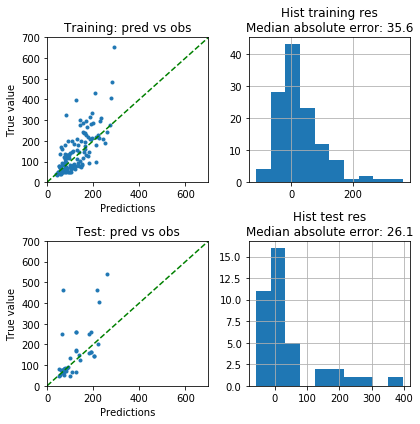

In [39]:


plt.figure(figsize=(6,6))
plt.subplot(221)
plt.plot(meuse_train['np_prediction'], meuse_train['lead'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0,700], [0,700], 'g--')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(222)
meuse_train['np_residual'].hist()
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_train['np_residual']))))
plt.subplot(223)
plt.plot(meuse_test['np_prediction'], meuse_test['lead'], '.')
plt.plot([0,700], [0,700], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(224)
meuse_test['np_residual'].hist()
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_test['np_residual']))))
plt.tight_layout()

## Ordinary kriging

Variogram parameters are set with trail and error.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 9500
Full Sill: 13500
Range: 900
Nugget: 4000 



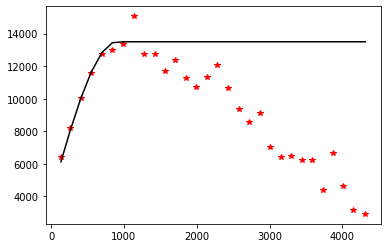

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [40]:
model = OrdinaryKriging(x=meuse_train['x'], y=meuse_train['y'], z=meuse_train['lead'], verbose=True,
                variogram_parameters=[13500, 900, 4000],
                enable_plotting=True, nlags=30, weight=True, variogram_model='spherical')
meuse_train['prediction'] = model.execute(style='points',xpoints=meuse_train['x'], ypoints=meuse_train['y'] )[0].data
meuse_train['kriging_residual'] = meuse_train['lead'] - meuse_train['prediction']
meuse_test['prediction'] = model.execute(style='points', xpoints=meuse_test['x'], ypoints=meuse_test['y'] )[0].data
meuse_test['kriging_residual'] = meuse_test['lead'] - meuse_test['prediction']

## Krig Model performance

- Performance on training data (kriging is an exact interpollator, so perfect prediction)
- Performance on test data

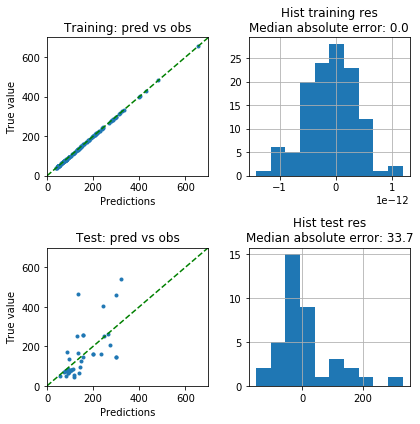

In [41]:
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.plot(meuse_train['prediction'], meuse_train['lead'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0,700], [0,700], 'g--')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(222)
meuse_train['kriging_residual'].hist()
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_train['kriging_residual']))))
plt.subplot(223)
plt.plot(meuse_test['prediction'], meuse_test['lead'], '.')
plt.plot([0,700], [0,700], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(224)
meuse_test['kriging_residual'].hist()
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_test['kriging_residual']))))
plt.tight_layout()

## Benchmark with Nearest Neighbours regression

Optimise number of neighbours with sklearn gridsearch

In [42]:
parameters = {'n_neighbors':np.arange(1,10)}
nn_model = KNeighborsRegressor()
nn_model_cv = GridSearchCV(nn_model, parameters)
nn_model_cv = nn_model_cv.fit(meuse_train[['x', 'y']], meuse_train['lead']) 
print('Optimal number of neighbours {}'.format(nn_model_cv.best_params_))
nn_model = nn_model_cv.best_estimator_
meuse_test['nn_prediction'] = nn_model.predict(meuse_test[['x', 'y']])
meuse_test['nn_residual'] = meuse_test['lead'] - meuse_test['nn_prediction']

Optimal number of neighbours {'n_neighbors': 4}


/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Text(0.5, 1.0, 'Compairing residuals\nmedian abs res NN: 38.8, Kriging 33.7, NP: 26.1\nmean abs res NN: 66.1, Kriging: 62.5, NP: 60.3')

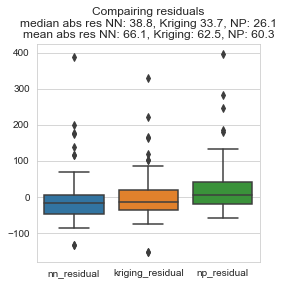

In [43]:
sb.set_style("whitegrid")
plt.figure(figsize=(4,4))
sb.boxplot(data=meuse_test[["nn_residual","kriging_residual","np_residual"]] )
plt.title('''Compairing residuals
median abs res NN: {:.1f}, Kriging {:.1f}, NP: {:.1f}
mean abs res NN: {:.1f}, Kriging: {:.1f}, NP: {:.1f}'''\
          .format(
    np.median(np.abs(meuse_test['nn_residual'])), 
    np.median(np.abs(meuse_test['kriging_residual'])),
    np.median(np.abs(meuse_test['np_residual'])),
    np.mean(np.abs(meuse_test['nn_residual'])), 
    np.mean(np.abs(meuse_test['kriging_residual'])),
    np.mean(np.abs(meuse_test['np_residual']))
))

## Help functions to sample a grid from a polygon

As found on http://portolan.leaffan.net/creating-sample-points-with-ogr-and-shapely-pt-2-regular-grid-sampling/

In [44]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step


## Sample a grid 

- Find the convex hull surrounding the measurements
- Sample a grid as found with the help functions

Text(0.5, 1.0, 'Sampled grid')

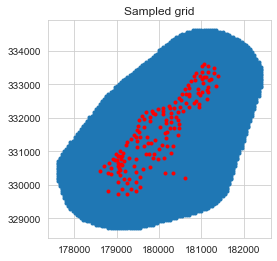

In [45]:
convex_hull = shapely.geometry.MultiPoint(list(meuse.geometry)).convex_hull.buffer(1050)
sampler = RegularGridSampler(convex_hull, x_interval=50, y_interval=50)
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(4,4))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(meuse['x'], meuse['y'], 'r.')
plt.title('Sampled grid')

## Krige a value for each grid point

In [46]:
grid_points['prediction'] = model.execute(style='points', xpoints=grid_points['x'], ypoints=grid_points['y'])[0].data
grid_points['prediction']

Executing Ordinary Kriging...



0       158.970993
1       158.970993
2       158.970993
3       158.970993
4       158.970993
           ...    
7859    158.970993
7860    158.970993
7861    158.970993
7862    158.970993
7863    158.970993
Name: prediction, Length: 7864, dtype: float64

## Transform data for a map

- Transform to lat long projection
- From long to wide format
- Fill in missing values

In [47]:
def plot_grid(grid_points, prediction, title):
    
    grid_points['prediction'] = prediction
    grid_points_gpd = grid_points.set_geometry('geometry')    
    grid_points_gpd.crs = {'init':'epsg:28992'}
    grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
    grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
    grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)
    
    grid_points_pivot = grid_points_gpd.pivot(values='prediction', columns='x', index='y').fillna(0)
    grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
    grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]
    plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
                 grid_points_pivot.values,20,cmap='GnBu', vmin=0, vmax=400)
    plt.scatter(meuse['x'], meuse['y'], c=meuse['lead'], cmap='GnBu', vmin=0, vmax=400)
    plt.plot(meuse['x'], meuse['y'], '.', ms=1)
    plt.title(title)
    plt.colorbar()
    
    return grid_points_pivot.values

Executing Ordinary Kriging...



/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


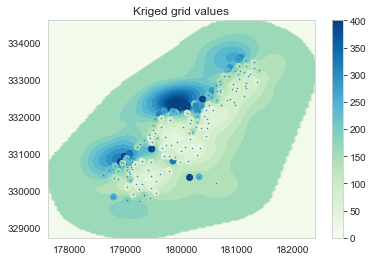

In [48]:
pred = model.execute(style='points', xpoints=grid_points['x'], ypoints=grid_points['y'])[0].data
z_krig = plot_grid(grid_points, pred, title="Kriged grid values")

## NP Plot

In [49]:
def eval_grid(grid_points, meuse, model_np):
    
    target_x = grid_points[['x', 'y']].copy()
    target_x-=norm_mean[['x', 'y']]
    target_x/=norm_std[['x', 'y']]

    df = meuse[['x', 'y', 'lead']].copy()
    df-=norm_mean
    df/=norm_std
    context_x = df[['x', 'y']]
    context_y = df['lead']

    context_x = torch.from_numpy(context_x.values).float()[None, :]
    context_y = torch.from_numpy(context_y.values).float()[None, :, None]
    target_x = torch.from_numpy(target_x.values).float()[None, :]

    # Make predictions
    model_np.eval()
    with torch.no_grad():

        y_pred, losses, extra = model_np.forward(context_x, context_y, target_x, target_x[:, :, :1])
    return yr, y_pred, losses, extra 


yr, y_pred, losses, extra  = eval_grid(grid_points, meuse, model_np)
std = extra['dist'].scale[0, :, 0] * 1
loc = extra['dist'].loc[0, :, 0] * 1
std *= norm_std['lead']
loc *= norm_std['lead']
loc += norm_mean['lead']

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


1

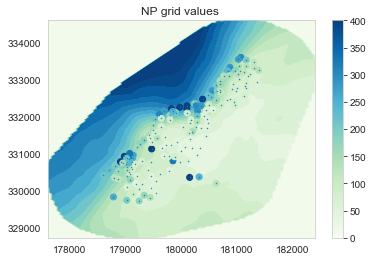

In [50]:
plot_grid(grid_points, (loc)*1.0, title="NP grid values ")
1

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


1

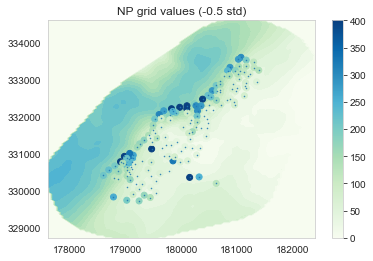

In [51]:
plot_grid(grid_points, (loc-0.5*std)*1.0, title="NP grid values (-0.5 std)")
1

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


1

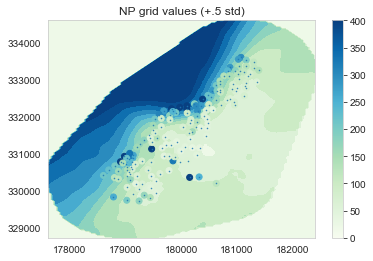

In [52]:
plot_grid(grid_points, (loc+0.25*std)*1.0, title="NP grid values (+.5 std)")
1

# Profile lines

In [53]:
im=z_np[::-1]
im[im==0]=np.nan

plt.title('NP profile lines')
plt.imshow?
plt.imshow(im, vmin=0, vmax=400, cmap='GnBu', interpolation='none')
plt.colorbar()
plt.hlines(80, 0, 100, colors='orange')
plt.vlines(50, 0, 130, colors='b')
plt.show()

# Show a couple of steep profiles
plt.plot(im[:, 50], c='b')
plt.plot(im[80], c='orange')
plt.ylim(0, 400)

NameError: name 'z_np' is not defined

In [ ]:
im=z_krig[::-1]
im[im==0]=np.nan

plt.title('Kriging profile lines')
plt.imshow(im, vmin=0, vmax=400, cmap='GnBu', interpolation='none' )
plt.colorbar()
plt.hlines(80, 0, 100, colors='orange')
plt.vlines(50, 0, 130, colors='b')
plt.show()

# Show a couple of steep profiles
plt.plot(im[:, 50], c='b')
plt.plot(im[80], c='orange')
plt.ylim(0, 400)

# Histogram

In [ ]:
# Historgram showing extrapolation
lw=3
plt.hist(meuse['lead'].values.flatten(), range=[0, 1000], histtype='step', density=True, label='true', lw=lw)

im = z_np * 1
im[im==0]=np.nan
plt.hist(im.flatten(), range=[0, 1000], histtype='step', density=True, label='np', lw=lw)


im2 = model.execute(style='points', xpoints=grid_points['x'], ypoints=grid_points['y'])[0].data
im2[im2==0]=np.nan
plt.hist(im2.flatten(), range=[0, 1000], histtype='step', density=True, label='kriging', lw=lw)

plt.legend()

In [ ]:
plt.scatter(meuse['x'], meuse['y'], c=meuse['lead'], cmap='GnBu', vmin=0, vmax=400)
plt.plot(meuse['x'], meuse['y'], '.', ms=1)
plt.colorbar()
plt.title('samples')

## Folium plot

In [ ]:
def color_function(value):
    if (value==0) | (value==np.nan) : return (0,0,0,0)
    else: 
        color = matplotlib.cm.YlOrRd(value) 
        return color

In [ ]:
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
m.add_children(plugins.ImageOverlay(image = (z_np/400), 
                                           opacity=0.7,origin='lower',
                                           colormap=color_function,
                                   bounds = [[np.min(grid_points_gpd['lat']), np.min(grid_points_gpd['long'])],
                                            [np.max(grid_points_gpd['lat']), np.max(grid_points_gpd['long'])]]))
for row in meuse_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=50, color=None, fill_opacity=1,
                    fill_color=scale(row[1][feature_to_plot])).add_to(m)
m.add_children(scale)